# Time-Optimal Control Exercise

In [1]:
import os
import time
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import (
    MX, DM, Function, Opti, integrator,
    vec, vcat, vertcat, horzcat, 
    sum1, sum2, sumsqr, sin, cos,
    gradient, jacobian, hessian
)

import casadi
casadi.__version__

'3.6.4'

In [4]:
# Physical constants

T = 1.0  # control horizon [s]
N = 20  # Number of control intervals

dt = T / N  # length of 1 control interval [s]

tgrid = np.linspace(0, T, N+1)

## Define continuous-time system

$\dot{x} = f(x,u)$

In [6]:
nx = 4

# Construct function for the ODE right-hand side
x = MX.sym('x', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
u = MX.sym('u', 2)  # control force [N]
rhs = vertcat(x[2:4], u)

# Continuous system dynamics as a CasADi Function
f = Function('f', [x, u], [rhs])
f

Function(f:(i0[4],i1[2])->(o0[4]) MXFunction)

## Define discrete-time system

$x_{k+1} = F(x_k, u_k)$

In [12]:
# Construct function for the ODE right-hand side
xk = MX.sym('xk', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
uk = MX.sym('uk', 2)  # control force [N]

f1 = f(xk, uk)
f2 = f(xk + dt/2 * f1, uk)
f3 = f(xk + dt/2 * f2, uk)
f4 = f(xk + dt * f3, uk)
xkp1 = xk + dt / 6 * (f1 + 2 * f2 + 2 * f3 + f4)

F = Function('F', [xk, uk], [xkp1], ['xk', 'uk'], ['xkp1'])
F

Function(F:(xk[4],uk[2])->(xkp1[4]) MXFunction)

## Waypoints

In [14]:
ref = horzcat(sin(np.linspace(0, 2, N+1)), cos(np.linspace(0,2,N+1))).T
ref.shape

(2, 21)

(DM(0), DM(1))

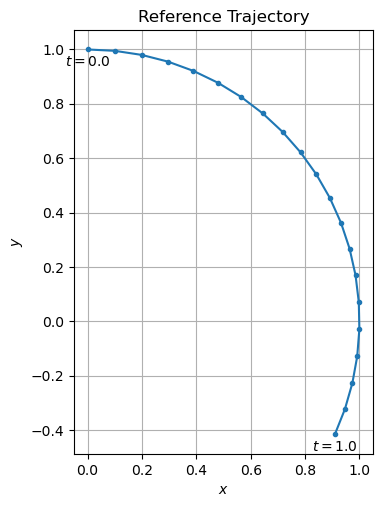

In [49]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))
ax.plot(ref[0, :].T, ref[1, :].T, '.-')
xy0 = np.array(ref[:, 0])
ax.annotate(f'$t={tgrid[0]}$', xy=xy0, xytext=(0, -5), textcoords='offset pixels', va='top', ha='center')
xy_end = np.array(ref[:, -1])
ax.annotate(f'$t={tgrid[-1]}$', xy=xy_end, xytext=(0, -5), textcoords='offset pixels', va='top', ha='center')
ax.grid()
ax.set_aspect('equal')
ax.set_title('Reference Trajectory')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.show()